In [2]:
from init_nb import init_notebook
config = init_notebook()
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bold_dementia.utils.configuration import get_config
from bold_dementia.utils.saving import save_run
from bold_dementia.stats.univariate import make_fc_data, run_test, export_results, merge_configs
from bold_dementia.connectivity import reshape_pvalues, plot_matrix, Atlas, pivot_resdf


In [3]:
ATLAS = "msdl"
atlas = Atlas.from_name(ATLAS)

In [4]:
expname = f"atlas-{ATLAS}_merged_ols-cenanom"
respath = Path(config["output_dir"]) / "statresults" / expname

In [5]:
null = pd.read_csv(respath / "null_distribution.csv", index_col=0)
resdf = pd.read_csv(respath / "resdf.csv", index_col=0)

In [6]:
permutation_scores = null.iloc[:, :-1].values
scores = resdf.beta_AD.values

In [7]:
score = np.stack([scores for _ in range(permutation_scores.shape[1])], axis=1)

In [8]:
np.abs(permutation_scores) >= np.abs(score)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False,  True, False, ..., False, False,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False]])

In [9]:
N = permutation_scores.shape[1]
pvalues = (np.sum(np.abs(permutation_scores) >= np.abs(score), axis=1)) / (N)

In [10]:
from statsmodels.stats.multitest import fdrcorrection
print(f"Correcting FDR with {len(pvalues)} comparisons")
_, pvalues_corr = fdrcorrection(pvalues)

Correcting FDR with 741 comparisons


In [11]:
np.sum(pvalues_corr < config["alpha"])

77

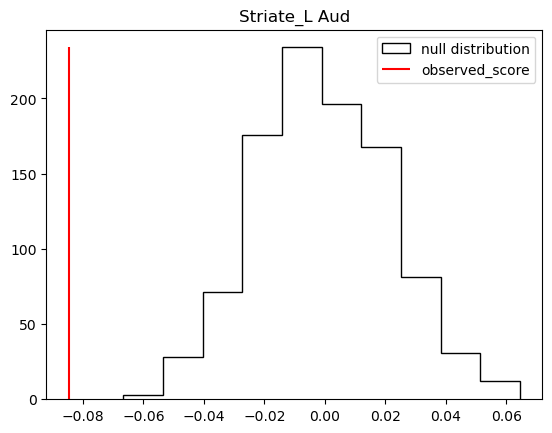

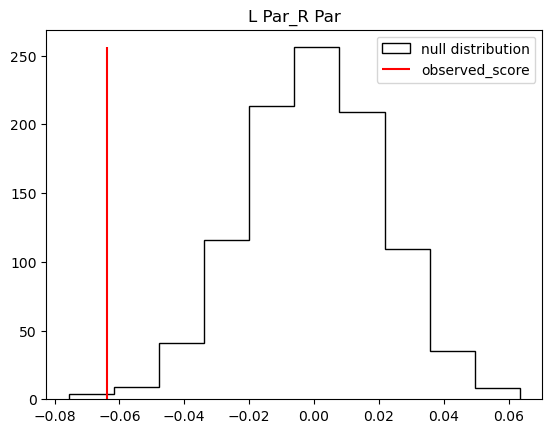

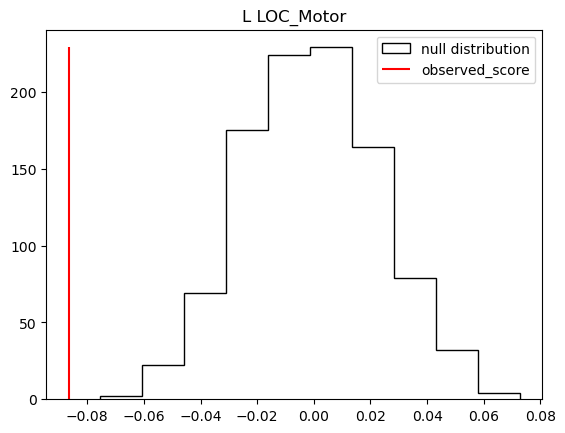

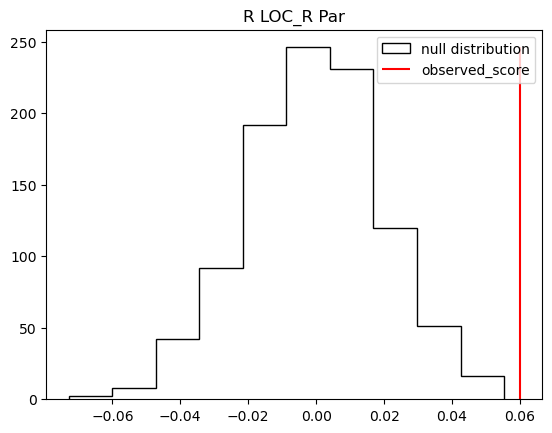

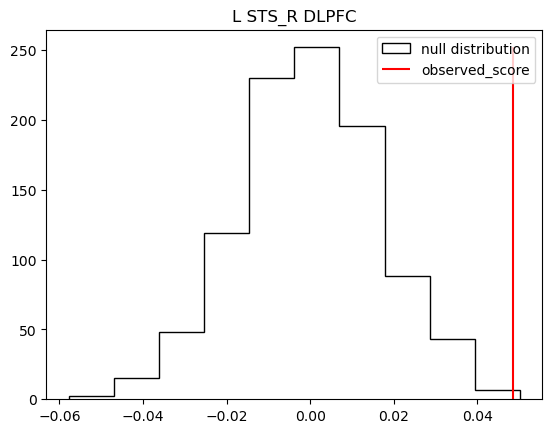

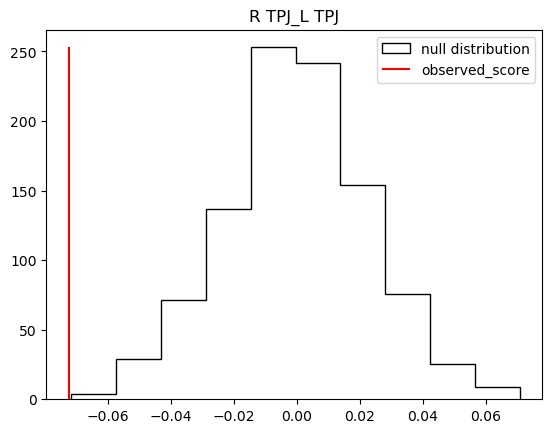

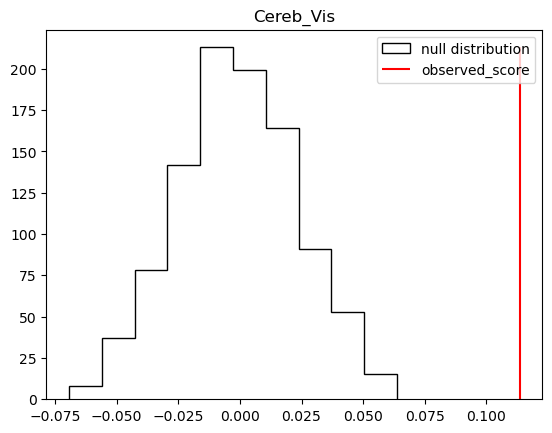

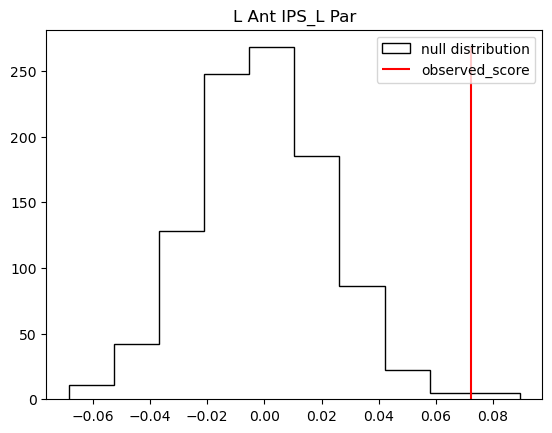

In [12]:
# TODO Plot distributions of significant edges
sig_idx = np.where(pvalues_corr <= config["alpha"])[0]

for idx in sig_idx[::10]:
    reference = permutation_scores[idx, :]
    observed_score = scores[idx]
    values, _, _ = plt.hist(reference, histtype="step", color="black", label="null distribution")
    plt.vlines(observed_score, 0, np.max(values), color="red", label="observed_score")
    plt.title(resdf.loc[idx, "edges"])
    plt.legend()
    plt.show()